In [1]:
import os
from random import choice

PROJECT_PATH = os.getcwd().split('notebooks')[0]
IMAGES_DIR = os.path.join(PROJECT_PATH, 'data', 'train', 'images')
# IMAGE_PATH = choice(os.listdir(IMAGES_DIR))
IMAGE_PATH = 'GuidetoClimbing-2020-GettyImages-643998567_2520-1-_jpg.rf.f592beaba0937bb9a019fc12bdc407bf.jpg'
LABELS_PATH = IMAGE_PATH.replace('.jpg', '.txt')

print(f'IMAGE_PATH: {IMAGE_PATH}')
print(f'LABELS_PATH: {LABELS_PATH}')

IMAGE_PATH: GuidetoClimbing-2020-GettyImages-643998567_2520-1-_jpg.rf.f592beaba0937bb9a019fc12bdc407bf.jpg
LABELS_PATH: GuidetoClimbing-2020-GettyImages-643998567_2520-1-_jpg.rf.f592beaba0937bb9a019fc12bdc407bf.txt


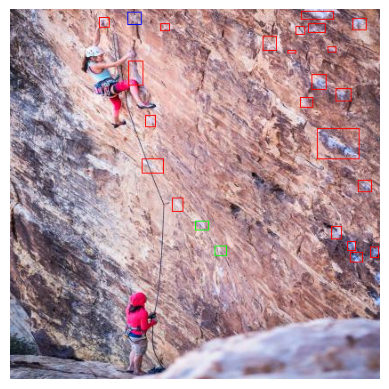

In [2]:
import cv2
import matplotlib.pyplot as plt

# load image
image_path = os.path.join(IMAGES_DIR, IMAGE_PATH)
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

height, width, _ = img.shape  # image size

labels_path = os.path.join(IMAGES_DIR.replace('images', 'labels'), LABELS_PATH)  # load YOLO labels
boxes = []

if os.path.exists(labels_path):
    with open(labels_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])

            x_center, y_center, w, h = map(float, parts[1:5])  # YOLO format: x_center, y_center, w, h (normalized)
            
            # convert to absolute coordinates
            x1 = int((x_center - w/2) * width)
            y1 = int((y_center - h/2) * height)
            x2 = int((x_center + w/2) * width)
            y2 = int((y_center + h/2) * height)
            
            boxes.append((class_id, x1, y1, x2, y2))

# variables to specify start and FINISH_BOX boxes
FOOT_START_BOX, HAND_START_BOX = range(15, 17)
FINISH_BOX = 22

# draw the boxes
for i, (class_id, x1, y1, x2, y2) in enumerate(boxes):
    if i == FOOT_START_BOX or i == HAND_START_BOX:
        color = (0, 255, 0)  # green for start and FINISH_BOX
    elif i == FINISH_BOX:
        color = (0, 0, 255)
    else:
        color = (255, 0, 0)  # red for other boxes
    cv2.rectangle(img, (x1, y1), (x2, y2), color)

# display image
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.show()

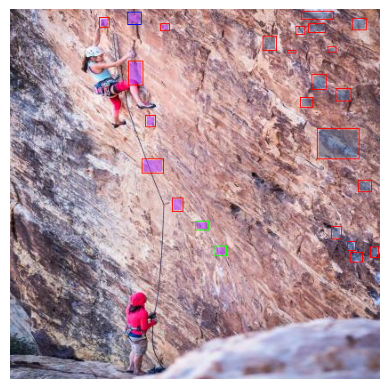

In [3]:
import numpy as np
from sklearn.cluster import DBSCAN
from random import randint

box_centers = np.array([[(x1 + x2) / 2, (y1 + y2) / 2] for _, x1, y1, x2, y2 in boxes])  # calculate box centers

# DBSCAN
EPS = 118
clustering = DBSCAN(eps=EPS, min_samples=1).fit(box_centers)  # 1 sample can be a cluster
cluster_labels = clustering.labels_  # cluster labels

# color generation for clusters
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
cluster_colors = [(randint(0, 255), randint(0, 255), randint(0, 255)) for _ in range(n_clusters)]

cluster_img = img.copy()  # create a copy of the image for visualization

# draw boxes with their cluster colors
for i, (class_id, x1, y1, x2, y2) in enumerate(boxes):
    # determine box outline color based on start/FINISH_BOX
    if i == FOOT_START_BOX or i == HAND_START_BOX:
        border_color = (0, 255, 0)  # green for start and FINISH_BOX
    elif i == FINISH_BOX:
        border_color = (0, 0, 255)
    else:
        border_color = (255, 0, 0)  # red for other boxes
    
    # draw box outline
    cv2.rectangle(cluster_img, (x1, y1), (x2, y2), border_color)
    
    # fill with cluster color
    if cluster_labels[i] != -1:  # non-noise points
        cluster_color = cluster_colors[cluster_labels[i]]
        # create overlay with transparency
        overlay = cluster_img.copy()
        cv2.rectangle(overlay, (x1+2, y1+2), (x2-2, y2-2), cluster_color, -1)
        alpha = 0.5  # transparency factor
        cluster_img = cv2.addWeighted(overlay, alpha, cluster_img, 1-alpha, 0)

# display image
plt.imshow(cluster_img)
plt.axis('off')
plt.show()

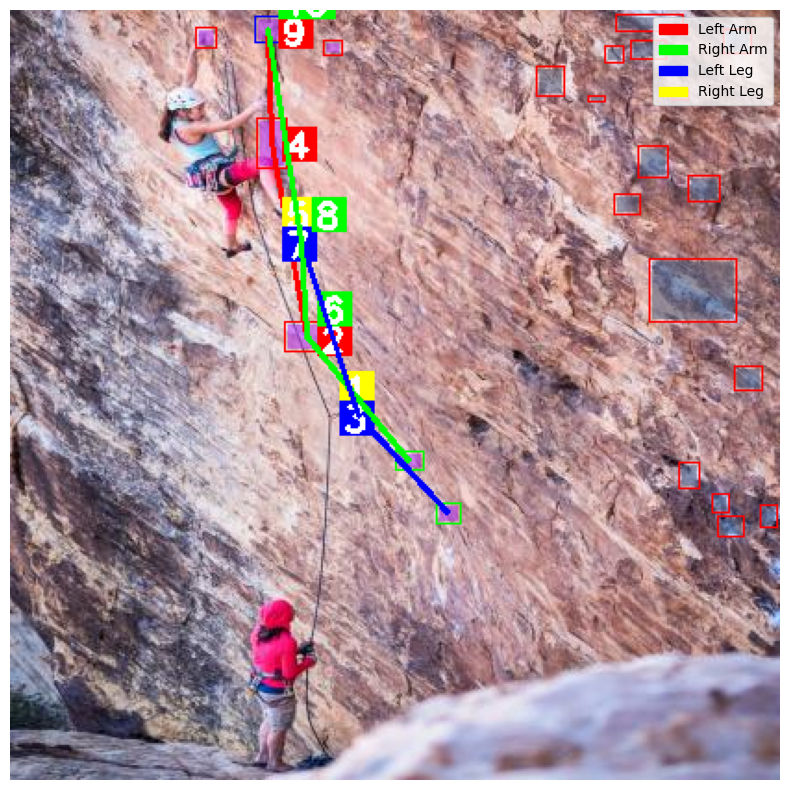

In [4]:
import networkx as nx
from copy import deepcopy
import matplotlib.patches as mpatches

# constants for physical limits
MAX_REACH = 120  # maximum distance a limb can move
MAX_LIMB_SEPARATION = 200  # maximum distance between limbs

# extract hold centers for easier calculations
hold_centers = np.array([[(x1 + x2) / 2, (y1 + y2) / 2] for _, x1, y1, x2, y2 in boxes])

# calculate distances between all holds
def distance(i, j):
    return np.linalg.norm(hold_centers[i] - hold_centers[j])

# create distance matrix
dist_matrix = np.zeros((len(boxes), len(boxes)))
for i in range(len(boxes)):
    for j in range(len(boxes)):
        dist_matrix[i, j] = distance(i, j)

# create graph for path finding
G = nx.Graph()
for i in range(len(boxes)):
    G.add_node(i, pos=tuple(hold_centers[i]))

# add edges between holds within reach distance
for i in range(len(boxes)):
    for j in range(len(boxes)):
        if 0 < dist_matrix[i, j] <= MAX_REACH:
            # apply cluster-based weight adjustment
            weight = dist_matrix[i, j]
            if cluster_labels[i] == cluster_labels[j]:
                weight *= 0.8  # favor moves within same cluster
            G.add_edge(i, j, weight=weight)

# state representation: (left_arm, right_arm, left_leg, right_leg, last_moved_limb)
start_state = (HAND_START_BOX, HAND_START_BOX, FOOT_START_BOX, FOOT_START_BOX, None)

# check if configuration is physically possible
def is_valid_state(state):
    la, ra, ll, rl, _ = state
    positions = [la, ra, ll, rl]
    
    # check limb separation
    for i in range(len(positions)):
        for j in range(i+1, len(positions)):
            if dist_matrix[positions[i], positions[j]] > MAX_LIMB_SEPARATION:
                return False
    
    # check center of gravity (simplified)
    center = np.mean([hold_centers[p] for p in positions[:4]], axis=0)
    convex_hull = [hold_centers[p] for p in [ll, rl]]
    if not any(np.all(center <= point) for point in convex_hull):
        # very simplified stability check
        return False
    
    return True

# check if we've reached the goal (both hands at FINISH_BOX)
def is_goal(state):
    la, ra, _, _, _ = state
    return la == FINISH_BOX and ra == FINISH_BOX

# find best path using A* search
def find_path():
    # priority queue for exploration
    queue = [(0, 0, start_state, [])]  # (priority, step_count, state, path)
    visited = set()
    
    while queue:
        _, steps, state, path = min(queue)
        queue.remove((_, steps, state, path))
        
        if is_goal(state):
            return path + [state]
        
        state_key = state[:4]  # exclude last_moved_limb from key
        if state_key in visited:
            continue
        
        visited.add(state_key)
        
        # try moving each limb to each reachable hold
        la, ra, ll, rl, last_moved = state
        for limb_idx, current_pos in enumerate([la, ra, ll, rl]):
            if limb_idx == last_moved:  # don't move same limb twice in a row
                continue
                
            for next_hold in G.neighbors(current_pos):
                # create new state by moving one limb
                new_state = list(state[:4])
                new_state[limb_idx] = next_hold
                new_state.append(limb_idx)
                new_state = tuple(new_state)
                
                if new_state[:4] not in visited and is_valid_state(new_state):
                    # calculate priority (favor fewer moves and shorter distances)
                    h = min(dist_matrix[new_state[0], FINISH_BOX], dist_matrix[new_state[1], FINISH_BOX])
                    priority = steps + 1 + h/100
                    queue.append((priority, steps + 1, new_state, path + [state]))
    
    return None  # no path found

# find best path
best_path = find_path()

# visualize path
if best_path:
    path_img = deepcopy(cluster_img)
    
    # draw path for each limb
    limb_colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0)]  # colors for each limb
    limb_names = ['Left Arm', 'Right Arm', 'Left Leg', 'Right Leg']
    
    for i in range(len(best_path)-1):
        state = best_path[i]
        next_state = best_path[i+1]
        
        # determine which limb moved
        for limb in range(4):
            if state[limb] != next_state[limb]:
                # draw line showing limb movement
                start_pt = tuple(map(int, hold_centers[state[limb]]))
                end_pt = tuple(map(int, hold_centers[next_state[limb]]))
                cv2.line(path_img, start_pt, end_pt, limb_colors[limb], 2)
                
                # add step number
                # add small offset based on limb type to prevent number overlap
                text_offset = [(8, 8), (8, -8), (-8, 8), (-8, -8)][limb]  # increased offsets for better visibility
                text_position = (end_pt[0] + text_offset[0], end_pt[1] + text_offset[1])
                # add background rectangle with same color as the limb
                text_size = cv2.getTextSize(str(i+1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
                cv2.rectangle(path_img, 
                             (text_position[0]-2, text_position[1]-text_size[1]-2),
                             (text_position[0]+text_size[0]+2, text_position[1]+2),
                             limb_colors[limb], -1)  # use limb color for background
                # draw text slightly bigger for better visibility
                cv2.putText(path_img, str(i+1), text_position, cv2.FONT_HERSHEY_SIMPLEX, 
                            0.6, (255, 255, 255), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(path_img)
    
    # create legend patches
    legend_patches = [mpatches.Patch(color=[c/255 for c in limb_colors[i]], label=limb_names[i]) 
                      for i in range(4)]
    
    # add legend
    plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1, 1))
    plt.axis('off')
    plt.show()
else:
    print('no valid path found')